In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import yaml
import copy
import pickle
import logging
import traceback
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
    
from geckoml.models import DenseNeuralNetwork, GRUNet
from geckoml.metrics import *
from geckoml.data import *
from geckoml.box import *

from aimlutils.echo.src.base_objective import *
import torch
import tqdm.auto as tqdm

sys.path.append("/glade/work/schreck/repos/holodec-ml/scripts/schreck/object")
from cosine_schedule import *

In [2]:
# Get the GPU
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [3]:
print(device)

cpu


In [4]:
logger = logging.getLogger(__name__)

In [5]:
random.seed(5006)

In [6]:
num_timesteps = 1440

starting_index = [0]

In [7]:
def rnn_box_test(model, exps, num_timesteps, in_array, env_array, y_scaler, output_cols, out_val, stable_thresh = 1.0, starting_index = [0]):
    
    epoch_loss = []
    box_loss_mae = []
    loss_fn = mean_absolute_error
    
    for start_time in starting_index:
        
        with torch.no_grad():
            # use initial condition @ t = 0 and get the first prediction
            pred_array = np.empty((len(exps), 1439-start_time, 2))
            h0 = model.init_hidden(torch.from_numpy(in_array[:, start_time, :]).float())
            pred, h0 = model.predict(in_array[:, start_time, :], h0)
            pred_array[:, 0, :] = pred
            loss = loss_fn(in_array[:, start_time+1, 1:3], pred)
            epoch_loss.append(loss)

            # use the first prediction to get the next, and so on for num_timesteps
            for k, i in enumerate(range(start_time + 1, num_timesteps)): 
                precursor = in_array[:, i, 0:1] 
                temperature = in_array[:, i, 3:4] 
                static_env = env_array[:, -5:]
                new_input = np.block([precursor, pred, temperature, static_env])
                pred, h0 = model.predict(new_input, h0)
                pred_array[:, k+1, :] = pred
                if i < (num_timesteps-1):
                    loss = loss_fn(in_array[:, i+1, 1:3], pred)
                    epoch_loss.append(loss)

        # loop over the batch to fill up results dict
        results_dict = {}
        for k, exp in enumerate(exps):
            results_dict[exp] = pd.DataFrame(y_scaler.inverse_transform(pred_array[k]), columns=output_cols[2:-1])
            results_dict[exp]['id'] = exp
            results_dict[exp]['Time [s]'] = out_val['Time [s]'].unique()[start_time:]
            results_dict[exp] = results_dict[exp].reindex(output_cols, axis=1)

        preds = pd.concat(results_dict.values())
        truth = out_val.loc[out_val['id'].isin(exps)]
        truth = truth.sort_values(['id', 'Time [s]']).reset_index(drop=True)
        preds = preds.sort_values(['id', 'Time [s]']).reset_index(drop=True)

        start_time_cond = truth['Time [s]'].isin(out_val['Time [s]'].unique()[start_time:])
        truth = truth[start_time_cond]

        # Check for instabilities
        preds = preds.copy()
        preds['Precursor [ug/m3]'] = 10**(preds['Precursor [ug/m3]'])
        truth['Precursor [ug/m3]'] = 10**(truth['Precursor [ug/m3]'])
        unstable = preds.groupby('id')['Precursor [ug/m3]'].apply(
            lambda x: x[(x > stable_thresh) | (x < -stable_thresh)].any())
        stable_exps = unstable[unstable == False].index
        failed_exps = unstable[unstable == True].index
        c1 = ~truth["id"].isin(failed_exps)
        c2 = ~preds["id"].isin(failed_exps)
        
        if c2.sum() == 0:
            box_mae = 1.0
        else:
            box_mae = mean_absolute_error(preds[c2].iloc[:, 2:-1], truth[c1].iloc[:, 2:-1])
        box_loss_mae.append(box_mae)
        
    box_mae = np.mean(box_mae)
    scaled_box_mae = np.mean(epoch_loss)
    
    return scaled_box_mae, box_mae, preds, truth #box_mae, scaled_box_mae, preds, truth


In [8]:
def rnn_box_train_one_epoch(model, optimizer, loss_fn, batch_size, 
                            exps, num_timesteps, in_array, env_array, hidden_weight = 1.0, starting_time = 0, grad_clip = 1.0):
    
    model.train()
    device = model._device()

    # Prepare the training dataset.
    num_experiments = in_array.shape[0]
    batches_per_epoch = int(np.ceil(num_experiments / batch_size))

    batched_experiments = list(range(batches_per_epoch))
    random.shuffle(batched_experiments)

    train_epoch_loss = []
        
    updates = 0 
    for j in batched_experiments:

        _in_array = torch.from_numpy(in_array[j * batch_size: (j + 1) * batch_size]).to(device).float()
        _env_array = torch.from_numpy(env_array[j * batch_size: (j + 1) * batch_size]).to(device).float()

        # Use initial condition @ t = 0 and get the first prediction
        # Clear gradient
        optimizer.zero_grad()
 
        new_input = _in_array[:, starting_time, :]
        h0 = model.init_hidden(new_input) 
        pred, h0 = model(new_input, h0)

        # get loss for the predicted output
        loss = loss_fn(_in_array[:, 1, 1:3], pred)

        # get gradients w.r.t to parameters
        loss.backward()
        train_epoch_loss.append(loss.item())

        # update parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        #lr_scheduler.step(epoch + updates / (1439 * batches_per_epoch))
        updates += 1

        for i in range(starting_time + 1, num_timesteps-1):
            # Use the last prediction to get the next prediction
            optimizer.zero_grad()
            
            # static envs 
            precursor = _in_array[:, i, 0] 
            temperature = _in_array[:, i, 3:4] 
            static_env = _env_array[:, -5:]
            new_input = torch.cat([torch.unsqueeze(precursor, 1), pred.detach(), temperature, static_env], 1)
            
        
            
            # predict hidden state
            h0_pred = model.init_hidden(new_input.cpu())
            # compute loss for the last hidden prediction
            hidden_loss = loss_fn(h0.detach(), h0_pred)
            
            # predict next state with the GRU
            pred, h0 = model(new_input, h0.detach())
            loss = loss_fn(_in_array[:, 1, 1:3], pred)
            
            # combine losses
            loss += hidden_weight * hidden_loss
            
            # compute the gradients
            loss.backward()
            train_epoch_loss.append(loss.item())

            # update parameters
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            
            #lr_scheduler.step(epoch + updates / (1439 * batches_per_epoch))
            updates += 1

    train_loss = np.mean(train_epoch_loss)
    
    return train_loss, model, optimizer

In [9]:
with open("/glade/work/keelyl/geckonew/gecko-ml/model.yml") as config_file:
        conf = yaml.load(config_file, Loader=yaml.FullLoader)

In [10]:
scalers = {"MinMaxScaler": MinMaxScaler, "StandardScaler": StandardScaler}

species =  conf['species'] # "dodecane"
dir_path = conf['dir_path']
summary_file = conf['summary_file']
aggregate_bins = conf['aggregate_bins']
bin_prefix = conf['bin_prefix']
input_vars = conf['input_vars']
output_vars = conf['output_vars']
scaler_type = "StandardScaler" #conf['scaler_type']
exps = conf['box_val_exps']
output_cols = conf['output_vars']

# Model settings
input_size = 9
output_size = 2
epochs = conf["rnn_network"]["epochs"]
batch_size = conf["rnn_network"]["batch_size"]
learning_rate = conf["rnn_network"]["lr"]
weight_decay = conf["rnn_network"]["l2_weight"]
n_layers = conf["rnn_network"]["n_layers"]
hidden_dim = conf["rnn_network"]["hidden_size"]
rnn_dropout = conf["rnn_network"]["rnn_dropout"]
hidden_weight = conf["rnn_network"]["k_decay"]
verbose = conf["rnn_network"]["verbose"]
lr_patience = 6
stopping_patience = 20

### Want to be able to reliably test L2 penalty = 0, but the 
### optuna loguniform prevents this -- so truncate below a certain value
weight_decay = weight_decay if weight_decay > 1e-12 else 0.0

# Load the data
in_train = pd.read_csv(f'/glade/scratch/cbecker/gecko_data/{species}_train_in_agg.csv')
out_train = pd.read_csv(f'/glade/scratch/cbecker/gecko_data/{species}_train_out_agg.csv')
in_val = pd.read_csv(f'/glade/scratch/cbecker/gecko_data/{species}_val_in_agg.csv')
out_val = pd.read_csv(f'/glade/scratch/cbecker/gecko_data/{species}_val_out_agg.csv')

in_train = in_train.drop(columns = [x for x in in_train.columns if x == "Unnamed: 0"])
out_train = out_train.drop(columns = [x for x in out_train.columns if x == "Unnamed: 0"])
in_val = in_val.drop(columns = [x for x in in_val.columns if x == "Unnamed: 0"])
out_val = out_val.drop(columns = [x for x in out_val.columns if x == "Unnamed: 0"])

num_timesteps = in_train['Time [s]'].nunique()

# Rescale training and validation / testing data
# if scaler_type == "MinMaxScaler":
#     x_scaler = scalers[scaler_type]((conf['min_scale_range'], conf['max_scale_range']))
# else:
#     x_scaler = scalers[scaler_type]()

x_scaler = StandardScaler()
y_scaler = StandardScaler()
scaled_in_train = x_scaler.fit_transform(in_train.drop(['Time [s]', 'id'], axis=1))
scaled_in_val = x_scaler.transform(in_val.drop(['Time [s]', 'id'], axis=1))

# y_scaler = get_output_scaler(x_scaler, output_vars, scaler_type, data_range=(
#     conf['min_scale_range'], conf['max_scale_range']))

scaled_out_train = y_scaler.fit_transform(out_train.drop(['Time [s]', 'id', 'Precursor [ug/m3]'], axis=1))
scaled_out_val = y_scaler.transform(out_val.drop(['Time [s]', 'id', 'Precursor [ug/m3]'], axis=1))

y = partition_y_output(scaled_out_train, conf["dense_network"]['output_layers'], aggregate_bins)
y_val = partition_y_output(scaled_out_val, conf["dense_network"]['output_layers'], aggregate_bins)

In [11]:
in_train

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
0,1.000000,-1.423785,0.000000,0.000000e+00,305.065364,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
1,301.207794,-1.426829,0.000494,3.058167e-11,304.978044,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
2,601.415588,-1.429875,0.000981,1.193708e-10,304.890766,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
3,901.623352,-1.432922,0.001459,2.814293e-10,304.803571,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
4,1201.831177,-1.435969,0.001929,5.148522e-10,304.716502,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
...,...,...,...,...,...,...,...,...,...,...,...
2302395,430498.968750,-10.631106,0.004719,1.256785e-03,261.094869,28.597493,0.813682,13.364777,2.212563,7.435525,Exp1599
2302396,430799.156250,-10.637511,0.004703,1.268518e-03,261.007971,28.597493,0.813682,13.364777,2.212563,7.435525,Exp1599
2302397,431099.375000,-10.643919,0.004687,1.280354e-03,260.920898,28.597493,0.813682,13.364777,2.212563,7.435525,Exp1599
2302398,431399.593750,-10.650330,0.004672,1.292289e-03,260.833700,28.597493,0.813682,13.364777,2.212563,7.435525,Exp1599


In [12]:
if species == "apin_O3":
    header = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/apin/"
if species == "dodecane":
    header = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/dodecane/"
if species == "toluene":
    header = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/toluene/"

logger.info(f"Loading training and validation data from cached location {header}")

with open(f"{header}/train.pkl", "rb") as fid:
    train_exps, in_array, env_array = pickle.load(fid)
with open(f"{header}/test.pkl", "rb") as fid:
    val_exps, val_in_array, val_env_array = pickle.load(fid)

In [13]:
class GRUNet(torch.nn.Module):
    
    """
    A GRU Neural Network Model that can support arbitrary numbers of hidden layers.

    Attributes:
        hidden_neurons: int
        - Number of neurons in each hidden layer
        hidden_layers: int
        - Number of hidden layers
        drop_prob: float
        - proportion of neurons randomly set to 0.
        device: str
        - CPU or GPU identifier
        
        gru: torch.nn.Module
        - Torch GRU model
        fc: torch.nn.Module
        - Torch Linear layer for resizing the output of the GRU
        relu: torch.nn.Module
        - The activation on the GRU output 
        hidden_model: torch.nn.Module
        - Torch Linear layer for the initial hidden state
    """
    
    def __init__(self, 
                 hidden_dim: int,
                 n_layers: int, 
                 drop_prob: float = 0.2): 
        
        super(GRUNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dr = drop_prob
        self.device = None
        
        self.gru = None
        self.fc = None
        self.relu = None
        self.hidden_model = None
        
    def build(self, 
              input_dim: int, 
              output_dim: int,
              weights_path: str = None) -> None:
        
        """
            Build the GRU network 
        
            input_dim: int
            - The size of the input
            output_dim: int
            - The number of prediction targets
        """
        
        self.gru = torch.nn.GRU(input_dim, self.hidden_dim, self.n_layers, batch_first=True, dropout=self.dr)
        self.fc = torch.nn.Linear(self.hidden_dim, output_dim)
        self.relu = torch.nn.LeakyReLU()
        self.hidden_model = torch.nn.Linear(input_dim, self.hidden_dim)
        
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        logger.info(
            f"The model contains {total_params} total parameters, {trainable_params} are trainable"
        )
        
        if isinstance(weights_path, str):
            if os.path.isfile(weights_path):
                self.load_weights(weights_path)
            else:
                logger.info(f"Failed to load model weights at {weights_path}")
        else:
            ## Weights initialization
            import torch.nn as nn
            import torch.nn.init as init
            
            def _weights_init(m):
                if isinstance(m, nn.Conv2d or nn.Linear):
                    init.xavier_normal_(m.weight)
                    m.bias.data.zero_()
                elif isinstance(m, nn.GRU or nn.LSTM):
                    for name, param in m.named_parameters():
                        if 'bias' in name:
                             nn.init.constant_(param, 0.0)
                        elif 'weight_ih' in name:
                             nn.init.kaiming_normal_(param)
                        elif 'weight_hh' in name:
                             nn.init.orthogonal_(param)
                elif isinstance(m, nn.BatchNorm2d or nn.BatchNorm1d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
            self.apply(_weights_init)
            
        
    def load_weights(self, weights_path: str) -> None:
        
        """
            Loads model weights given a valid weights path
            
            weights_path: str
            - File path to the weights file (.pt)
        """
        logger.info(f"Loading model weights from {weights_path}")
        
        try:
            checkpoint = torch.load(
                weights_path,
                map_location=lambda storage, loc: storage
            )
            self.load_state_dict(checkpoint["model_state_dict"])
        except Exception as E:
            logger.info(
                f"Failed to load model weights at {weights_path} due to error {str(E)}"
            )
        
        
    def forward(self, 
                x: torch.Tensor, 
                h: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        
        """
            Pass the inputs through the model and return the prediction
        
            Inputs
            x: torch.Tensor
            - The input containing precursor, gas, aerosol, and envionmental values
            h: torch.Tensor
            - The hidden state to the GRU at time t
            
            Returns
            out: torch.Tensor
            - The encoded input
            h: torch.Tensor
            - The hidden state returned by the GRU at time t + 1
        """
        
        x = x.unsqueeze(1)
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, 
                    x: torch.Tensor) -> torch.Tensor:
        
        """
            Predict a hidden state for the initial input to the model at t = 0
        
            Inputs
            x: torch.Tensor
            - The input containing precursor, gas, aerosol, and envionmental values
            
            Returns: torch.Tensor
            - A hidden state corresponding to the initial condition
        """
        
        device = self._device() if self.device is None else self.device
        hidden = self.hidden_model(x.to(device)).unsqueeze(0)
        hidden = torch.cat([hidden.clone() for x in range(self.n_layers)]) if self.n_layers > 1 else hidden
        return hidden
    
    def _device(self) -> str:
        
        """
            Set and return the device that the model was placed onto.
        
            Inputs: None
            Returns: str
            - Device identifier
        
        """
        
        self.device = next(self.parameters()).device
        return self.device
    
    def predict(self, 
                x: np.array, 
                h: np.array) -> (np.array, np.array):
        
        """
            Predict method for running the model in box mode.
            Handles converting numpy tensor input to torch
            and moving the data to the GPU
        
            Inputs
            x: np.array
            - The input containing precursor, gas, aerosol, and envionmental values
            h: np.array
            - The hidden state to the GRU at time t
            
            Returns: str
            x: np.array
            - The encoded input
            h: np.array
            - The hidden state to the GRU at time t + 1
        
        """
        
        device = self._device() if self.device is None else self.device
        with torch.no_grad():
            x = torch.from_numpy(x).float().to(device)
            x, h = self.forward(x, h)
        return x.cpu().detach().numpy(), h

In [14]:
model = GRUNet(hidden_dim, n_layers, rnn_dropout)
model.build(input_size, output_size)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
# Load the train and test losses
criterion = torch.nn.SmoothL1Loss() # Huber loss
val_criterion = torch.nn.L1Loss()  # Mean absolute error

# Load an optimizer
logger.info("Loading the optimizer")        
        
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate,
    weight_decay=weight_decay
)

# Load an scheduler for the RNN model
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience = lr_patience, 
    verbose = True,
    min_lr = 1.0e-13
)

# lr_scheduler = CosineAnnealingLR_with_Restart(
#     optimizer, 
#     model=model,
#     T_max = 4,
#     T_mult = 1.5,
#     out_dir = "./",
#     take_snapshot = False,
#     eta_min = 1.0e-09
# )

In [16]:
epochs = range(500)
results_dict = defaultdict(list)

for epoch in epochs:
    
    train_loss, model, optimizer = rnn_box_train_one_epoch(
        model, 
        optimizer, 
        criterion, 
        batch_size, 
        train_exps, 
        num_timesteps,
        in_array, 
        env_array,
        hidden_weight = hidden_weight
    )

    val_loss, step_val_loss, _, _ = rnn_box_test(
        model, 
        val_exps, 
        num_timesteps, 
        val_in_array, 
        val_env_array, 
        y_scaler, 
        output_cols, 
        out_val, 
        starting_index = starting_index
    )
    
    # Get the last learning rate
    learning_rate = optimizer.param_groups[0]['lr']
    
    # Put things into a results dictionary
    results_dict["epoch"].append(epoch)
    results_dict["train_loss"].append(train_loss)
    results_dict["val_loss"].append(val_loss)
    results_dict["step_val_loss"].append(step_val_loss)
    results_dict["lr"].append(learning_rate)
    df = pd.DataFrame.from_dict(results_dict).reset_index()
    
    # Save the dataframe to disk
    df.to_csv(os.path.join(conf["output_path"], "training_log.csv"), index = False)

    print(
        f"Epoch: {epoch} train_loss: {train_loss:.6f} val_loss: {val_loss:.6f} step_val_loss: {step_val_loss:.6f} lr: {learning_rate}"
    )

    # Update the scheduler and anneal the learning rate if required
    lr_scheduler.step(val_loss)
    # optimizer.param_groups[0]['lr'] = 0.1 * optimizer.param_groups[0]['lr']
    
    # Save the model if its the best so far.
    if val_loss == min(results_dict["val_loss"]):
        state_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss
        }
        torch.save(state_dict, os.path.join(conf["output_path"], "best.pt"))

    # Stop training if we have not improved after X epochs
    best_epoch = [i for i,j in enumerate(results_dict["val_loss"]) if j == min(results_dict["val_loss"])][0]
    offset = epoch - best_epoch
    if offset >= stopping_patience:
        break

# Select the best loss
best_box_mae = min(results_dict["val_loss"])

# Return box_mae to optuna
results = {
    "box_mae": best_box_mae
}

KeyboardInterrupt: 

In [ ]:
val_loss, step_val_loss, pred, truth = rnn_box_test(
        model, 
        val_exps, 
        num_timesteps, 
        val_in_array, 
        val_env_array, 
        y_scaler, 
        output_cols, 
        out_val, 
        starting_index = [0]
    )

In [ ]:
print(val_loss)

In [87]:
a = truth['id'] == 'Exp1600'

In [88]:
%matplotlib inline

In [89]:
pred[a]

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],id
0,301.207794,NaN,0.000756,1.218404e-05,Exp1600
1,601.415588,NaN,0.000758,1.096865e-05,Exp1600
2,901.623352,NaN,0.000751,9.938850e-06,Exp1600
3,1201.831177,NaN,0.000738,9.209213e-06,Exp1600
4,1502.038940,NaN,0.000728,8.696833e-06,Exp1600
...,...,...,...,...,...
1434,430799.156250,NaN,0.000723,2.917847e-07,Exp1600
1435,431099.375000,NaN,0.000723,3.978917e-07,Exp1600
1436,431399.593750,NaN,0.000723,4.884660e-07,Exp1600
1437,431699.781250,NaN,0.000724,5.659281e-07,Exp1600


In [90]:
truth[a]

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],id
0,301.207794,3.721285e-02,0.000708,0.000003,Exp1600
1,601.415588,3.674244e-02,0.001421,0.000009,Exp1600
2,901.623352,3.627777e-02,0.002110,0.000016,Exp1600
3,1201.831177,3.581876e-02,0.002777,0.000026,Exp1600
4,1502.038940,3.536536e-02,0.003423,0.000038,Exp1600
...,...,...,...,...,...
1434,430799.156250,4.460552e-10,0.009388,0.004241,Exp1600
1435,431099.375000,4.404294e-10,0.009367,0.004252,Exp1600
1436,431399.593750,4.348721e-10,0.009345,0.004264,Exp1600
1437,431699.781250,4.293824e-10,0.009324,0.004275,Exp1600


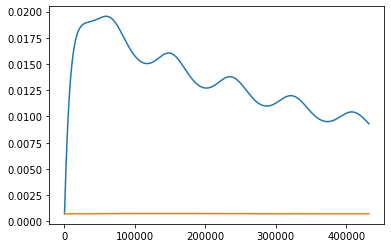

In [91]:
plt.plot(truth[a]['Time [s]'], truth[a]['Gas [ug/m3]'])
plt.plot(truth[a]['Time [s]'], pred[a]['Gas [ug/m3]'])
plt.show()